In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk import PorterStemmer as stemmer
from bs4 import BeautifulSoup 
import string
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("C:/Users/khist/AmazonProductReview/reviews/Roborock_reviews.csv")

In [3]:
data.head()

,Rating,Review_title,Product_review
0,5.0 out of 5 stars,BEST ROB VAC (in this price range),I purchased the Roborock E4 over a month ago.
1,4.0 out of 5 stars,A True LIFE SAVER!!!!,I've only noticed a few minor issues with this...
2,5.0 out of 5 stars,Great value robot vac,We have had this little vac for almost two mo...
3,5.0 out of 5 stars,My new helper,"First of all, I used to be a person who saw a ..."
4,1.0 out of 5 stars,Gets stuck on EVERYTHING. Constant supervision...,Grabbed this on Cyber Monday and was really e...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Rating          1367 non-null   object
 1   Review_title    1378 non-null   object
 2   Product_review  1378 non-null   object
dtypes: object(3)
memory usage: 32.4+ KB


In [5]:
data.dropna(inplace = True)

In [6]:
def strip_rating(r):
    return str(r).split('.')[0]

In [7]:
data['Rating'] = data['Rating'].apply(strip_rating)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1367 entries, 0 to 1366
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Rating          1367 non-null   object
 1   Review_title    1367 non-null   object
 2   Product_review  1367 non-null   object
dtypes: object(3)
memory usage: 42.7+ KB


In [9]:
data.head()

,Rating,Review_title,Product_review
0,5,BEST ROB VAC (in this price range),I purchased the Roborock E4 over a month ago.
1,4,A True LIFE SAVER!!!!,I've only noticed a few minor issues with this...
2,5,Great value robot vac,We have had this little vac for almost two mo...
3,5,My new helper,"First of all, I used to be a person who saw a ..."
4,1,Gets stuck on EVERYTHING. Constant supervision...,Grabbed this on Cyber Monday and was really e...


In [10]:
nltk.download('stopwords')
STOPWORDS=stopwords.words("english") #is, he, that, etc.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def Remove_Emojify(review):
    return review.encode('ascii', 'ignore').decode('ascii') 

def clean_text(text):
    ps=stemmer()
    
    text = Remove_Emojify(text) # remove Emojis
    
    text_cleaned = "".join([x for x in text if x not in string.punctuation]) # remove punctuation
    
    text_cleaned = re.sub(' +', ' ', text_cleaned) # remove extra white spaces
    
    text_cleaned = text_cleaned.lower() # converting to lowercase
    
    tokens = text_cleaned.split(" ")
    tokens = [token for token in tokens if token not in STOPWORDS] # Taking only those words which are not stopwords
    text_cleaned = " ".join([ps.stem(token) for token in tokens])
    
    return text_cleaned

data['cleaned_review']=data['Product_review'].apply(lambda x:clean_text(x))

In [13]:
data.head()

,Rating,Review_title,Product_review,cleaned_review
0,5,BEST ROB VAC (in this price range),I purchased the Roborock E4 over a month ago.,purchas roborock e4 month ago
1,4,A True LIFE SAVER!!!!,I've only noticed a few minor issues with this...,ive notic minor issu vacuum sometim doesnt ent...
2,5,Great value robot vac,We have had this little vac for almost two mo...,littl vac almost two month thought time review...
3,5,My new helper,"First of all, I used to be a person who saw a ...",first use person saw robot vacuum worth coupl ...
4,1,Gets stuck on EVERYTHING. Constant supervision...,Grabbed this on Cyber Monday and was really e...,grab cyber monday realli excit first clean ses...


In [14]:
df = data[['Rating','cleaned_review']] 
df['Rating'] = df['Rating'].apply(lambda x: 'neg' if int(x) <= 3 else 'pos')
df.columns = ['label', 'text']
df = pd.concat([df, df.label.astype('str').str.get_dummies()], axis=1, sort=False)
df = df[['text', 'neg','pos']]
df.head()

,text,neg,pos
0,purchas roborock e4 month ago,0,1
1,ive notic minor issu vacuum sometim doesnt ent...,0,1
2,littl vac almost two month thought time review...,0,1
3,first use person saw robot vacuum worth coupl ...,0,1
4,grab cyber monday realli excit first clean ses...,1,0


In [15]:
import ktrain
from ktrain import text

In [20]:
trn, val, preproc = text.texts_from_df(df, 
                                       'text', # name of column containing review text
                                       label_columns=['neg','pos'],
                                       maxlen=75, 
                                       max_features=100000,
                                       preprocess_mode='bert',
                                       val_pct=0.1)

['neg', 'pos']
     neg  pos
318    1    0
560    1    0
100    0    1
508    0    1
782    0    1
['neg', 'pos']
      neg  pos
170     0    1
1163    0    1
471     1    0
1170    0    1
975     1    0
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [21]:
model = text.text_classifier('bert', train_data=trn, preproc=preproc)

Is Multi-Label? False
maxlen is 75
done.


In [22]:
learner = ktrain.get_learner(model, train_data=trn, batch_size=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
205/205 [==============================] - 356s 2s/step - loss: 0.6017 - accuracy: 0.7008
Epoch 2/5
205/205 [==============================] - 347s 2s/step - loss: 0.5444 - accuracy: 0.7244
Epoch 3/5
205/205 [==============================] - 337s 2s/step - loss: 0.7503 - accuracy: 0.6325
Epoch 4/5
205/205 [==============================] - 211s 1s/step - loss: 4.4049 - accuracy: 0.5664


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


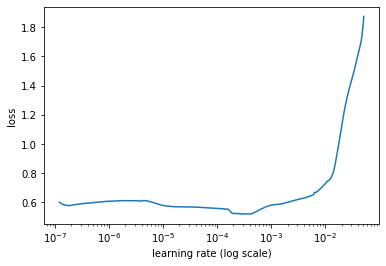

In [23]:
learner.lr_find(max_epochs=5)
learner.lr_plot()

In [25]:
learner.validate(val_data=val)

              precision    recall  f1-score   support

           0       0.68      0.69      0.69        49
           1       0.83      0.82      0.82        88

    accuracy                           0.77       137
   macro avg       0.75      0.76      0.75       137
weighted avg       0.77      0.77      0.77       137



array([[34, 15],
       [16, 72]], dtype=int64)

In [33]:
learner.fit_onecycle(lr = 2e-5, epochs = 1)



begin training using onecycle policy with max lr of 2e-05...
205/205 [==============================] - 329s 2s/step - loss: 0.0875 - accuracy: 0.9732


In [34]:
learner.validate(val_data=val)

              precision    recall  f1-score   support

           0       0.80      0.57      0.67        49
           1       0.79      0.92      0.85        88

    accuracy                           0.80       137
   macro avg       0.80      0.75      0.76       137
weighted avg       0.80      0.80      0.79       137



array([[28, 21],
       [ 7, 81]], dtype=int64)

In [35]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [40]:
data = ['waste of money', 
        'beautiful as a gift',
        'I use it all day, everyday']

In [41]:
predictor.predict(data)

['neg', 'pos', 'pos']